1. Neuronowy model dawcy krwi (Blood Transfusion Service Center).
Projekt wykonany przez Dominika Tamiołło oraz Sebastiana Smulskiego


Dane do uczenia maszynowego znajdują się w pliku transfusion.data. Rozpoczniemy od zaznajomienia się z naszym modelem danych.

Repozytorium: https://github.com/Sob3k/blood-transfusion


In [8]:
f = open ('transfusion.data','r')
lines = f.readlines()
for i in lines [:10]:
    print (i)
f.close()

Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),"whether he/she donated blood in March 2007"

2 ,50,12500,98 ,1

0 ,13,3250,28 ,1

1 ,16,4000,35 ,1

2 ,20,5000,45 ,1

1 ,24,6000,77 ,0

4 ,4,1000,4 ,0

2 ,7,1750,14 ,1

1 ,12,3000,35 ,0

2 ,9,2250,22 ,1



Opis poszczególnych pól 

1. Recency - ilość miesięcy ile upłynęło od ostatniego oddania krwi.
2. Frequency - totalna liczba donacji.
3. Monetary - ilość oddanej krwi z milimetrach sześciennych.
4. Time - ilość miesięcy od pierwszej donacji krwi.
5. Wartość binarna oznaczająca czy dawca oddał krew w marcu 2007 roku.


Plik transfusion.data w rzeczywistości jest plikiem formatu .csv o czym świadczy separacja danych poprzez przecinek. Zaimportujemy teraz dane poprzez bilioteke Pandas

Dane nie wyglądają na znormalizowane, ustandaryzujmy zakres wartości. Zmienne, które są mierzone w różnych skalach, nie wpływają w równym stopniu na dopasowanie modelu i wyuczoną funkcję modelu i mogą w końcu spowodować powstanie błędu.

In [9]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

transfusion_dataset = pd.read_csv("transfusion.data")
transfusion_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Recency (months)                            748 non-null    int64
 1   Frequency (times)                           748 non-null    int64
 2   Monetary (c.c. blood)                       748 non-null    int64
 3   Time (months)                               748 non-null    int64
 4   whether he/she donated blood in March 2007  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


Nasz dataset składa się z 748 obiektów, każdy zawiera w sobie 5 danych opisanych wcześniej. Ostatnia kolumna jest w rzeczywistości polem które chcemy "przewidywać" poprzez nasz model uczenia maszynowego. Dla klarowności zmienimy jego nazwę na "target" tak jak opisywaliśmy to na zajęciach laboratoryjnych. 

In [10]:
transfusion_dataset.rename(columns={'whether he/she donated blood in March 2007': 'target'}, inplace=True)
transfusion_dataset.head(1)

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),target
0,2,50,12500,98,1


C:\Tools\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


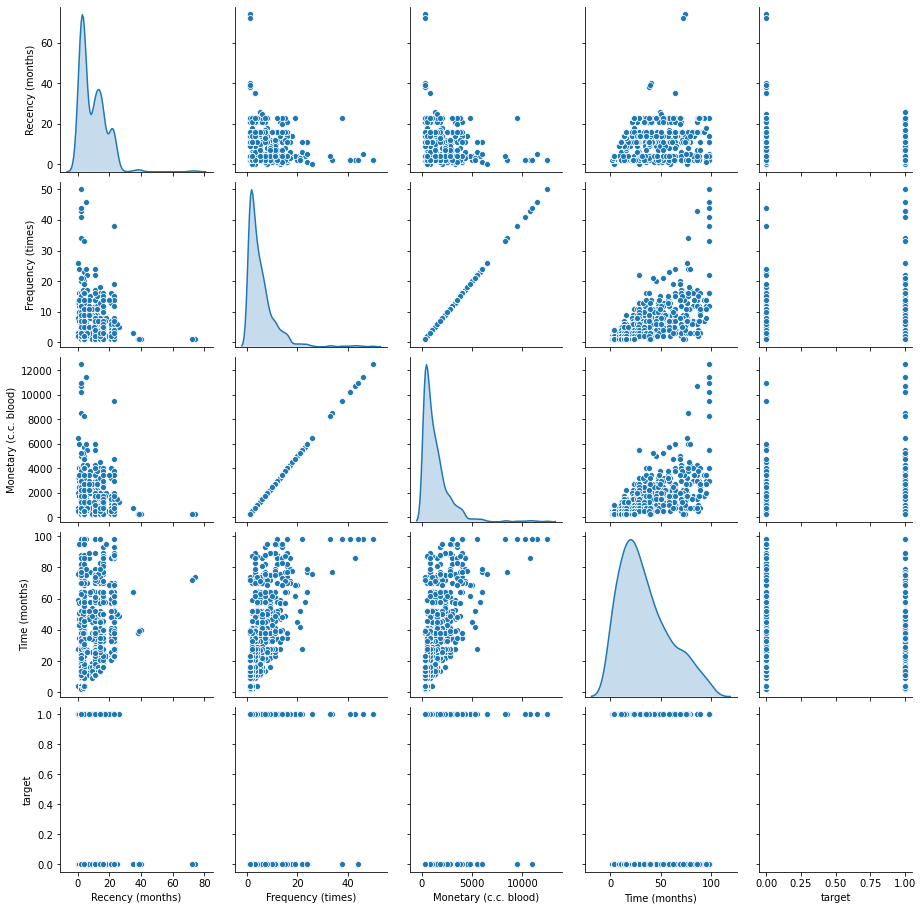

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb

sb.pairplot(transfusion_dataset, diag_kind="kde")

In [10]:
Cel naszego projektu 

W tym projekcie będziemy starali się przewidzieć za pomocą naszego modelu czy poszczególny dawca odda krew następnym razem kiedy będzie taka możliwość. 
Będziemy używać klasyfikatora binarnego; Są tylko dwie możliwości
0 dawca nie odda krwi
1 dawca odda krew


SyntaxError: invalid syntax (<ipython-input-10-dc046a4a3238>, line 1)

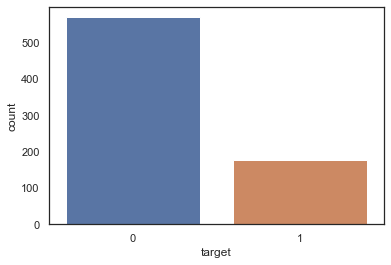

In [11]:
from collections import Counter
import seaborn as sns
import numpy as np
sns.set(style="white")
Counter(transfusion_dataset.target)
sns.countplot(x='target', data=transfusion_dataset)

Jak widać dane nie są zbalansowane co może zaowocować nie najlepszymi wynikami. Najlepszą sytuacją byłoby gdyby rozkład 0 oraz 1 w target był mniej więcej równy.

In [ ]:
Podział danych na dane treningowe i dane uczące

In [13]:
from sklearn.model_selection import train_test_split
data = transfusion_dataset.drop(columns='target')

#standaryzacja wartosci
scaler = StandardScaler()
transfusion_scaled = scaler.fit_transform(data)

transfusion_train_data, transfusion_test_data, \
transfusion_train_target, transfusion_test_target = train_test_split(
    transfusion_scaled,
    transfusion_dataset.target,
    test_size=0.25,
    random_state=42,
    stratify=transfusion_dataset.target
)

Po sprawdzeniu budowy dataset'u stwierdziliśmy że najlepszym wyborem będzie regresja logistyczna.
Aby się upewnić co do naszej decyzji użyliśmy klasyfikatora TPOT, którego zaprezentowaliśmy poniżej

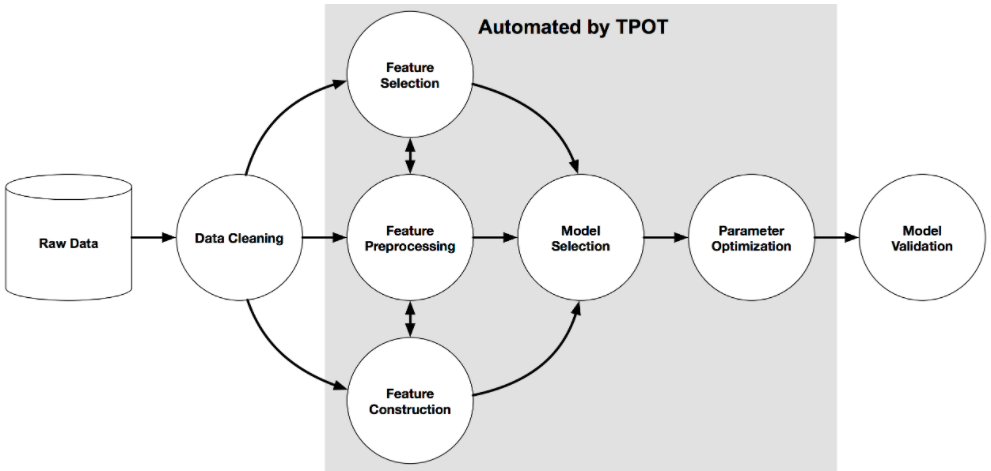

In [14]:
from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score

t = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring='roc_auc',
    random_state=42,
    disable_update_check=True,
    config_dict='TPOT light'
)
t.fit(transfusion_train_data, transfusion_train_target)

# AUC score for tpot model
tpot_auc_score = roc_auc_score(transfusion_test_target, t.predict_proba(transfusion_test_data)[:, 1])
print(f'\nAUC score: {tpot_auc_score:.4f}')

# Print best pipeline steps
print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(t.fitted_pipeline_.steps, start=1):
    # Print idx and transform
    print(f'{idx}. {transform}')

C:\Tools\Anaconda\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")



Generation 1 - Current best internal CV score: 0.7422459184429089

Generation 2 - Current best internal CV score: 0.7423330644124078

Generation 3 - Current best internal CV score: 0.742784111060445

Generation 4 - Current best internal CV score: 0.742784111060445

Generation 5 - Current best internal CV score: 0.7429815535834687

Best pipeline: LogisticRegression(StandardScaler(RobustScaler(input_matrix)), C=0.1, dual=False, penalty=l2)

AUC score: 0.7859

Best pipeline steps:
1. RobustScaler()
2. StandardScaler()
3. LogisticRegression(C=0.1, random_state=42)


Jak widać nasze przypuszczenia się sprawdziły.

In [64]:
id = 2
print(transfusion_test_data[id,:].reshape(1,-1))

[[   2   11 2750   26]]


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

logistic_regression = LogisticRegression(C=0.1, dual=False)
clf = logistic_regression.fit(transfusion_train_data, transfusion_train_target)

id=41
pred = logistic_regression.predict(transfusion_test_data[id,:].reshape(1,-1))
print("Model predicted for donor {0} value {1}".format(id, pred))

print("Real value for donor \"{0}\" is {1}".format(id, transfusion_test_target[id]))

pred_prob = logistic_regression.predict_proba(transfusion_test_data[id,:].reshape(1,-1))
print(pred_prob)

pred = logistic_regression.predict(transfusion_test_data)

acc = accuracy_score(transfusion_test_target, pred)
print("Model accuracy is {0:0.2f}".format(acc))

conf_matrix = confusion_matrix(transfusion_test_target, logistic_regression.predict(transfusion_test_data))
print(conf_matrix)

print ("Cross validation on 6 pieces of data")

scores = cross_val_score(LogisticRegression(), transfusion_scaled, transfusion_dataset.target, cv=6)
print(scores)

Model predicted for donor 41 value [0]
Real value for donor "41" is 0
[[0.65940425 0.34059575]]
Model accuracy is 0.78
[[142   1]
 [ 40   4]]
Cross validation on 6 pieces of data
[0.8        0.76       0.752      0.776      0.80645161 0.76612903]


Model został wytrenowany dobrze bo każda część tego zbioru posiada podobne wyniki dokładności.